# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


from tqdm import tqdm
import os

In [10]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
# using SQLite Table to read data.
#@con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [13]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [14]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [15]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [19]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [20]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [22]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [24]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [25]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [28]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:42<00:00, 2234.63it/s]


In [32]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [0]:
final['cleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [34]:
#Taking random 60000 ponits

final_data = final.sample(n=70000)

final_data.shape

(70000, 11)

In [35]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_df = final_data.sort_values(by = "Time")
print(final.shape)
final_df.head(5)

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...
417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,2000-06-03,Research,I'm getting crazy.<p>Is it really impossible t...,getting crazy really impossible today not find...
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,2000-08-09,Very easy to use,This are so much easier to use than the Wilson...,much easier use wilson paste colors colors vib...


In [36]:
# 80k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
# class label
Y = final_df["Score"]
print("shape of Y:", Y.shape)

shape of X: (70000,)
shape of Y: (70000,)


In [37]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 52)
X_traincv, X_cv, y_traincv, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print(X_train.shape, y_train.shape, x_test.shape)
print(X_traincv.shape, y_traincv.shape, y_cv.shape)

(49000,) (49000,) (21000,)
(32830,) (32830,) (16170,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
bowt=count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowts = count_vect.transform(x_test)
print("the type of count vectorizer ",type(bowts))
print("the shape of out text BOW vectorizer ",bowts.get_shape())
print("the number of unique words ", bowts.get_shape()[1])

some feature names  ['aback', 'abandon', 'abandoned', 'ability', 'able', 'abroad', 'absent', 'absolute', 'absolutely', 'absolutly']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 8804)
the number of unique words  8804


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=5000,min_df=10)
tfidft=tf_idf_vect.fit_transform(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidfts = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(tfidft))
print("the shape of out text TFIDF vectorizer ",tfidft.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidft.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.4] Word2Vec

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=5,window=5,)

In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13657
sample words  ['pleased', 'storage', 'drawer', 'not', 'take', 'lot', 'counter', 'space', 'holds', 'k', 'cups', 'sardines', 'medium', 'sized', 'lightly', 'smoked', 'fish', 'packed', 'oil', 'traditional', 'results', 'savory', 'product', 'may', 'eaten', 'directly', 'tin', 'best', 'crackers', 'bit', 'mayonaise', 'mustard', 'one', 'thing', 'prepared', 'difficult', 'open', 'nice', 'coffee', 'chocolately', 'hint', 'would', 'def', 'buy', 'beautiful', 'aroma', 'cheap', 'days', 'still', 'find']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 49000/49000 [01:14<00:00, 653.45it/s]

49000


In [0]:
from sklearn import preprocessing
Xavg=preprocessing.normalize(sent_vectors_tr)

In [37]:
print(Xavg.shape)

(49000, 50)


In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in x_test.values:
   list_of_sent_ts.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_ts=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=6,window=5,)

In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13657
sample words  ['pleased', 'storage', 'drawer', 'not', 'take', 'lot', 'counter', 'space', 'holds', 'k', 'cups', 'sardines', 'medium', 'sized', 'lightly', 'smoked', 'fish', 'packed', 'oil', 'traditional', 'results', 'savory', 'product', 'may', 'eaten', 'directly', 'tin', 'best', 'crackers', 'bit', 'mayonaise', 'mustard', 'one', 'thing', 'prepared', 'difficult', 'open', 'nice', 'coffee', 'chocolately', 'hint', 'would', 'def', 'buy', 'beautiful', 'aroma', 'cheap', 'days', 'still', 'find']


In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 21000/21000 [00:33<00:00, 624.89it/s]

21000
50


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg = preprocessing.normalize(sent_vectors)

In [43]:
print(Xtsavg.shape)

(21000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [15:20<00:00, 53.21it/s]


In [0]:
xtfidf = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [06:35<00:00, 66.13it/s]


In [0]:
xtstfidf = preprocessing.normalize(tfidf_sent_vectorsts)

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
#Training the model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clf = RandomForestClassifier(class_weight = "balanced")
param_grid = {'max_depth':depth,'n_estimators':trees,}


model = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 10,n_jobs = 3,scoring='roc_auc',)
model.fit(bowt, y_train)
print("best depth = ", model.best_params_)
print("Accuracy on train data = ", model.best_score_*100)
Features = model.best_params_

best depth =  {'max_depth': 10, 'n_estimators': 1000}
Accuracy on train data =  91.40484756151943


In [0]:
#Assigning the result
optimal_depth = Features.get('max_depth')
optimal_estimator = Features.get('n_estimators')
print(optimal_depth)
print(optimal_estimator)


10
1000


In [0]:
#Training with max depth and estimatore
clf = RandomForestClassifier(max_depth = optimal_depth,n_estimators=optimal_estimator)

clf.fit(bowt,y_train)

pred = clf.predict(bowts)


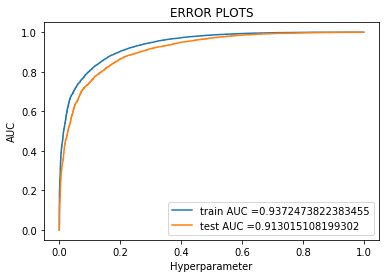

Train confusion matrix
[[ 6244  1394]
 [ 4519 36843]]
Test confusion matrix
[[ 2642   739]
 [ 2146 15473]]


In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(bowt)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(bowts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(bowt)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(bowts)))

In [0]:
#Creating AUC array
auc_ts=[]
auc_tr=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc=auc(train_fpr, train_tpr)
    tsauc=auc(test_fpr, test_tpr)
    auc_ts.append(tsauc)
    auc_tr.append(trauc)
    
trainp=np.array(auc_tr)
testp=np.array(auc_ts)    

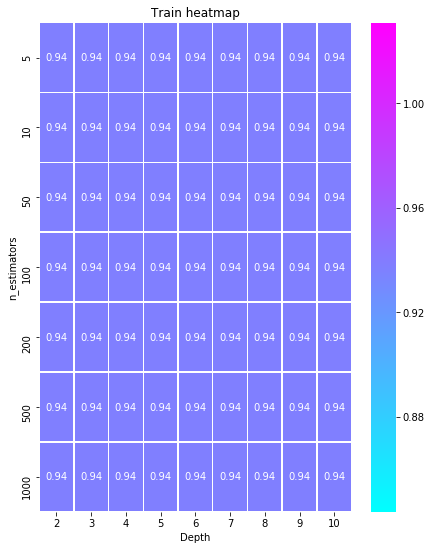

In [0]:
#Train heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Cols= len(param_grid['max_depth'])
Index=len(param_grid['n_estimators'])
df = pd.DataFrame(trainp.reshape(Index, Cols), index=param_grid['n_estimators'], columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()
#RdYlGn_r


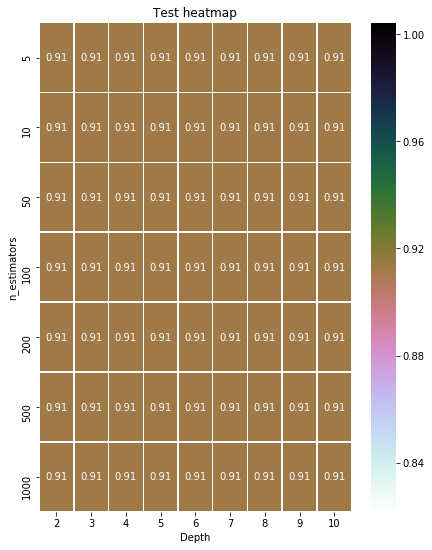

In [0]:
#Test heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Cols= len(param_grid['max_depth'])
Index=len(param_grid['n_estimators'])
df = pd.DataFrame(testp.reshape(Index, Cols), index=param_grid['n_estimators'], columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cubehelix_r', linewidths=0.5, annot=True)
plt.title("Test heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()
#RdYlGn_r


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model.predict(bowts))
cm

array([[ 2642,   739],
       [ 2146, 15473]])

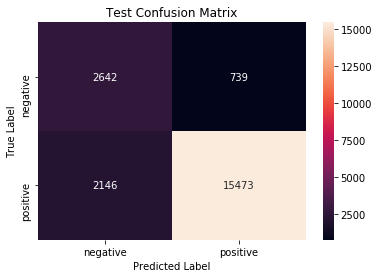

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, model.predict(bowt))
cm

array([[ 6244,  1394],
       [ 4519, 36843]])

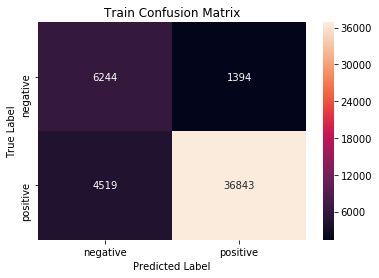

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

In [0]:
#building with max depth
clfbow = RandomForestClassifier(max_depth = optimal_depth,n_estimators=optimal_estimator,class_weight = 'balanced')
clfbow.fit(bowt,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
importances = clfbow.feature_importances_
std = np.std([clfbow.feature_importances_ for tree in clfbow.estimators_],
             axis=0)
#https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
#indices = np.argsort(importances)[::20]
indices = np.array(importances).argpartition(-2)[-20:]

#Topfeat = np.array(list(map(abs,clfbow.feature_importances_))).argsort()[4970:5000]

In [0]:
vocab = count_vect.vocabulary_

ind=list(vocab.values())
indexes = np.array(ind).argsort()

words=list(vocab.keys())
Filtered_words=[]
for i in indexes:
    Filtered_words.append(words[i])

In [0]:
Topbow={}          
for index in indices:
    for i in tf_idf_vect.vocabulary_:
        if tf_idf_vect.vocabulary_[i] == index:
            Topbow[i]=clfbow.feature_importances_[index]
            

In [0]:
print(Topbow)

{'btw': 0.014106645565259689, 'avoid': 0.006998080879262533, 'result': 0.016712680623747325, 'bring': 0.014689472236403291, 'years not': 0.01769135079167771, 'higher': 0.020347140151267512, 'joy': 0.021620676047572073, 'trader': 0.021925589798067142, 'certainly': 0.022696271545769267, 'processing': 0.031046017908525122}


In [0]:
from wordcloud import WordCloud

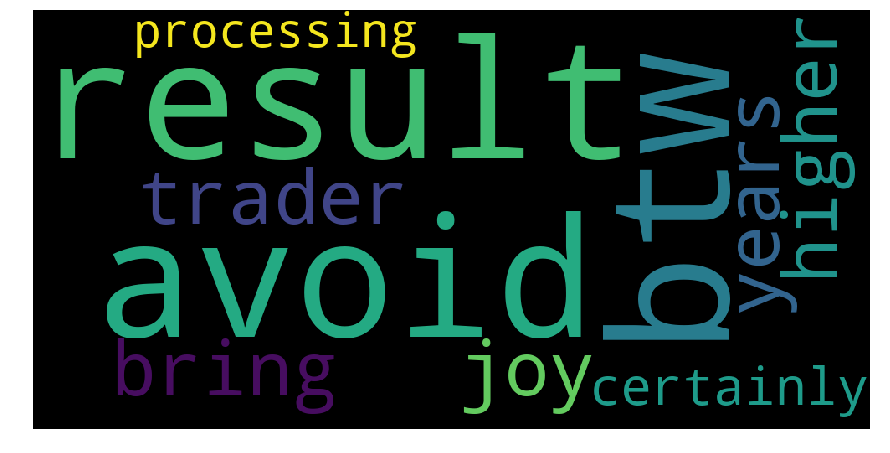

In [0]:
#https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python
#https://www.datacamp.com/community/tutorials/wordcloud-python
import matplotlib.pyplot as plt

#convert list to string and generate
unique_string=(" ").join(Topbow)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


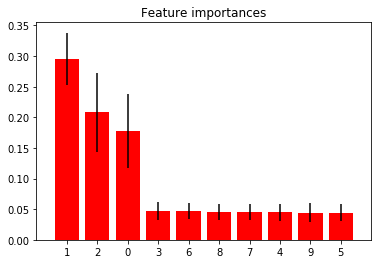

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X=bowt
y=y_train
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
#Training the model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clf1 = RandomForestClassifier(class_weight = "balanced")
param_grid = {'max_depth':depth,'n_estimators':trees}


model1 = GridSearchCV(estimator = clf1,param_grid=param_grid ,cv = 3,n_jobs = 3,scoring='roc_auc')
model1.fit(tfidft, y_train)
print("best depth = ", model1.best_params_)
print("Accuracy on train data = ", model1.best_score_*100)
Features1 = model1.best_params_

best depth =  {'max_depth': 10, 'n_estimators': 1000}
Accuracy on train data =  91.05619937134632


In [0]:
#Assigning the result
optimal_depth1 = Features1.get('max_depth')
optimal_estimator1 = Features1.get('n_estimators')
print(optimal_depth1)
print(optimal_estimator1)


10
1000


In [0]:
#Training with max depth and estimatore
clf1 = RandomForestClassifier(max_depth = optimal_depth1,n_estimators=optimal_estimator1)

clf1.fit(tfidft,y_train)

pred1 = clf1.predict(tfidfts)


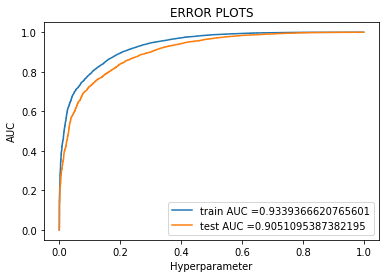

Train confusion matrix
[[ 6226  1412]
 [ 4843 36519]]
Test confusion matrix
[[ 2579   802]
 [ 2340 15279]]


In [0]:
train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, model1.predict_proba(tfidft)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(tfidfts)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model1.predict(tfidft)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model1.predict(tfidfts)))

In [0]:
#Creating AUC array
auc_ts1=[]
auc_tr1=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc=auc(train_fpr1, train_tpr1)
    tsauc=auc(test_fpr1, test_tpr1)
    auc_ts1.append(tsauc)
    auc_tr1.append(trauc)
    
trainp1=np.array(auc_tr1)
testp1=np.array(auc_ts1)    

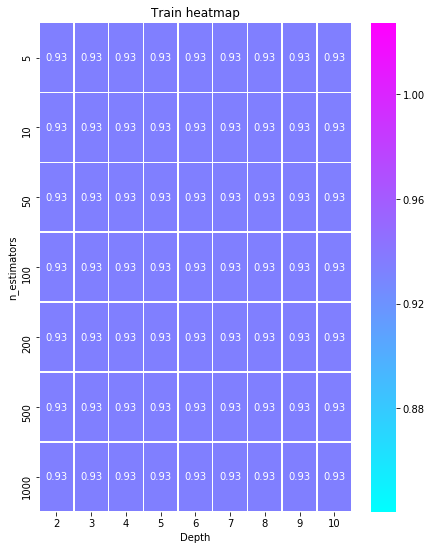

In [0]:
#Train heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Cols= len(param_grid['max_depth'])
Index=len(param_grid['n_estimators'])
df = pd.DataFrame(trainp1.reshape(Index, Cols), index=param_grid['n_estimators'], columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



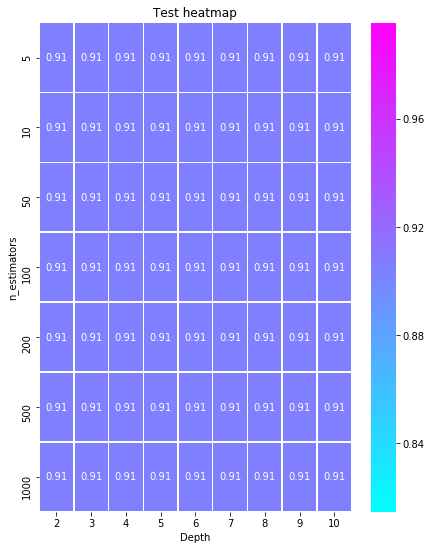

In [0]:
#Test heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Cols= len(param_grid['max_depth'])
Index=len(param_grid['n_estimators'])
df = pd.DataFrame(testp1.reshape(Index, Cols), index=param_grid['n_estimators'], columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Test heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_train,model1.predict(tfidft))
cm1

array([[ 6226,  1412],
       [ 4843, 36519]])

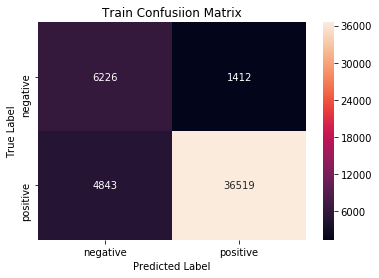

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test,model1.predict(tfidfts))
cm1

array([[ 2579,   802],
       [ 2340, 15279]])

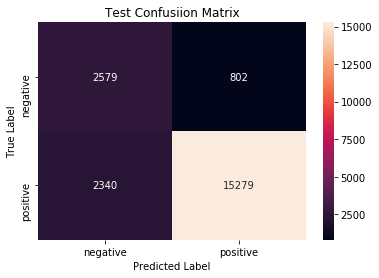

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#building with max depth
clftfidf = RandomForestClassifier(max_depth = optimal_depth1,class_weight = 'balanced')
clftfidf.fit(tfidft,y_train)



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification
importances = clftfidf.feature_importances_
std = np.std([clftfidf.feature_importances_ for tree in clftfidf.estimators_],
             axis=0)
#https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
#indices = np.argsort(importances)[::20]
indices = np.array(importances).argpartition(-2)[-20:]

#Topfeat = np.array(list(map(abs,clfbow.feature_importances_))).argsort()[4970:5000]

In [0]:
Toptfidf={}          
for index in indices:
    for i in tf_idf_vect.vocabulary_:
        if tf_idf_vect.vocabulary_[i] == index:
            Toptfidf[i]=clftfidf.feature_importances_[index]
            

In [0]:
print(Toptfidf)

{'thought': 0.013123451360750488, 'not waste': 0.011859815629044873, 'completely': 0.006282003326962525, 'away': 0.009867846743311339, 'picture': 0.006787476967467079, 'tasty': 0.00809985424513796, 'not buy': 0.015581891999347116, 'worst': 0.021810129192076828, 'delicious': 0.02550123889033471, 'waste': 0.020310021353180618, 'reviews': 0.019252387846620766, 'terrible': 0.017182647141081094, 'return': 0.02438607102315502, 'waste money': 0.024694965857871926, 'easy': 0.020551757917767588, 'horrible': 0.027878720947796386, 'not': 0.03615098804746424, 'best': 0.04044936450356245, 'loves': 0.05133222782822683, 'great': 0.07719206448002337}


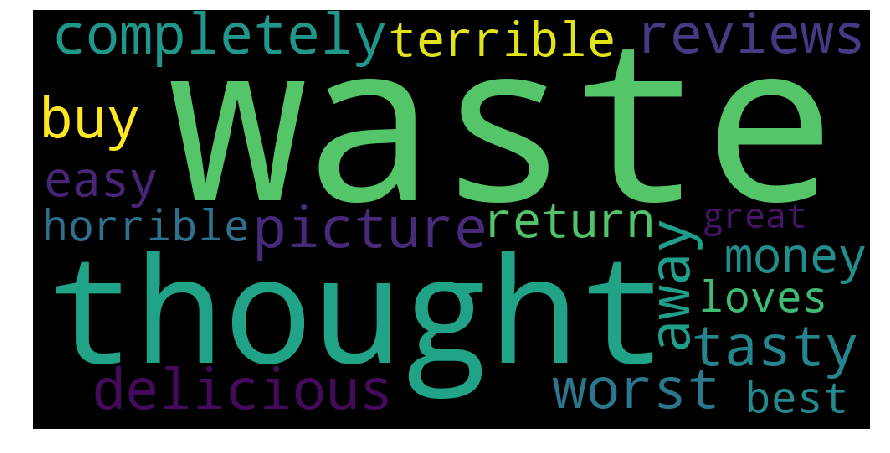

In [0]:
#https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#convert list to string and generate
unique_string=(" ").join(Toptfidf)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [46]:
#Training the model

trees = [5, 10, 50, 100, 200,250,300,500]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clf2 = RandomForestClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'n_estimators':trees}

model2 = GridSearchCV(estimator = clf2,param_grid=param_grid ,cv = 10,n_jobs = 3,scoring='roc_auc')
model2.fit(Xavg, y_train)
print("best depth = ", model2.best_params_)
print("Accuracy on train data = ", model2.best_score_*100)
Features2 = model2.best_params_

best depth =  {'max_depth': 10, 'n_estimators': 500}
Accuracy on train data =  89.05500383712324


In [47]:
#Assigning the result
optimal_depth2 = Features2.get('max_depth')
optimal_estimator2 = Features2.get('n_estimators')
print(optimal_depth2)
print(optimal_estimator2)


10
500


In [0]:
#Training with max depth and estimatore
clf2 = RandomForestClassifier(max_depth = optimal_depth2,n_estimators=optimal_estimator2)

clf2.fit(Xavg,y_train)

pred2= clf2.predict(Xtsavg)


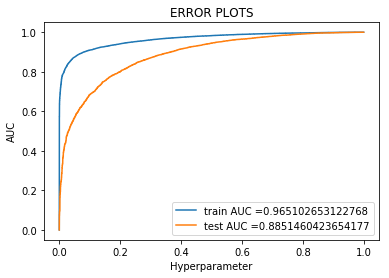

Train confusion matrix
[[ 7025   626]
 [ 4104 37245]]
Test confusion matrix
[[ 2294  1008]
 [ 2240 15458]]


In [49]:
#AUC curve
train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, model2.predict_proba(Xavg)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model2.predict(Xavg)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model2.predict(Xtsavg)))

In [0]:
#Creating AUC array
auc_ts2=[]
auc_tr2=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc2=auc(train_fpr2, train_tpr2)
    tsauc2=auc(test_fpr2, test_tpr2)
    auc_ts2.append(tsauc2)
    auc_tr2.append(trauc2)
    
trainaw=np.array(auc_tr2)
testaw=np.array(auc_ts2)    

In [0]:
ind=len(param_grid['max_depth'])

col=len(param_grid['n_estimators'])

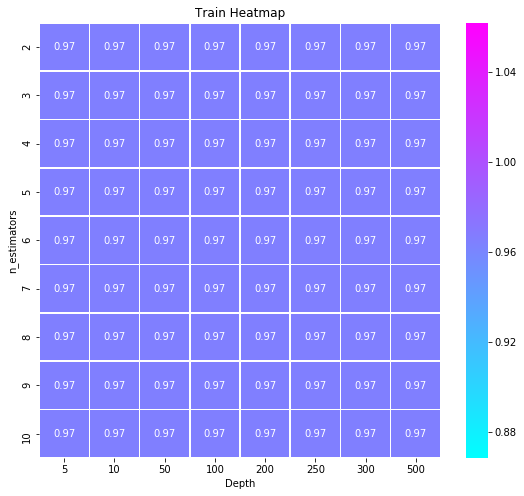

In [52]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(trainaw.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train Heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



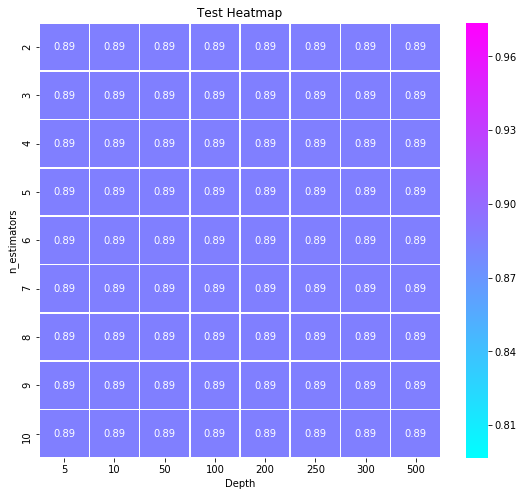

In [53]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(testaw.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Test Heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [54]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train,model2.predict(Xavg))
cm2

array([[ 7025,   626],
       [ 4104, 37245]])

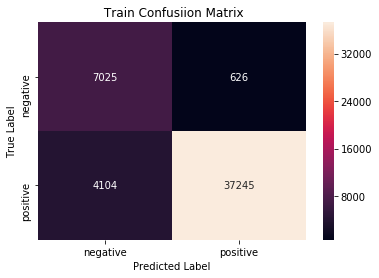

In [55]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title(" Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [56]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test,model2.predict(Xtsavg))
cm2

array([[ 2294,  1008],
       [ 2240, 15458]])

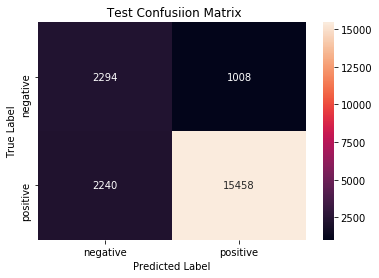

In [57]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title(" Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [63]:
#Training Model
trees = [5, 10, 50, 100, 200, 500,600,750]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

clf3 = RandomForestClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'n_estimators':trees}

model3 = GridSearchCV(estimator = clf3,param_grid=param_grid ,cv = 10,n_jobs = 3,scoring='roc_auc')
model3.fit(xtfidf, y_train)
print("best depth = ", model3.best_params_)
print("Accuracy on train data = ", model3.best_score_*100)
Features3 = model3.best_params_

best depth =  {'max_depth': 10, 'n_estimators': 750}
Accuracy on train data =  86.85457651300933


In [64]:
#Assigning the result
optimal_depth3 = Features3.get('max_depth')
optimal_estimator3 = Features3.get('n_estimators')
print(optimal_depth3)
print(optimal_estimator3)


10
750


In [65]:
#Training with max depth and estimatore
clf3 = RandomForestClassifier(max_depth = optimal_depth3,n_estimators=optimal_estimator3)

clf3.fit(xtfidf,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

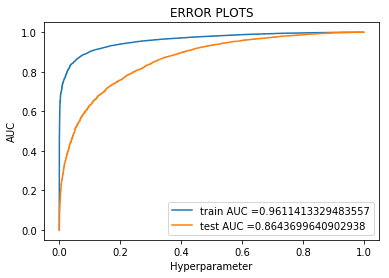

Train confusion matrix
[[ 6839   812]
 [ 3903 37446]]
Test confusion matrix
[[ 2119  1183]
 [ 2169 15529]]


In [66]:
train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, model3.predict_proba(xtfidf)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(xtstfidf)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model3.predict(xtfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model3.predict(xtstfidf)))

In [0]:
#Creating AUC array
auc_ts3=[]
auc_tr3=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc3=auc(train_fpr3, train_tpr3)
    tsauc3=auc(test_fpr3, test_tpr3)
    auc_ts3.append(tsauc3)
    auc_tr3.append(trauc3)
    
train3=np.array(auc_tr3)
test3=np.array(auc_ts3)    

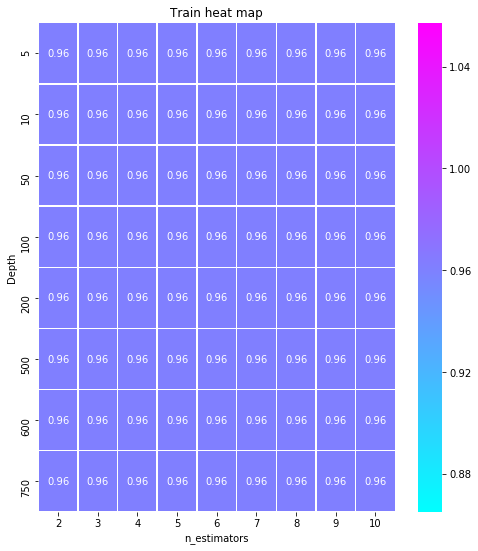

In [68]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index=len(param_grid['n_estimators']) 
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(train3.reshape(Index, Cols), index=param_grid['n_estimators'] , columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("n_estimators")
plt.ylabel("Depth")
plt.show()


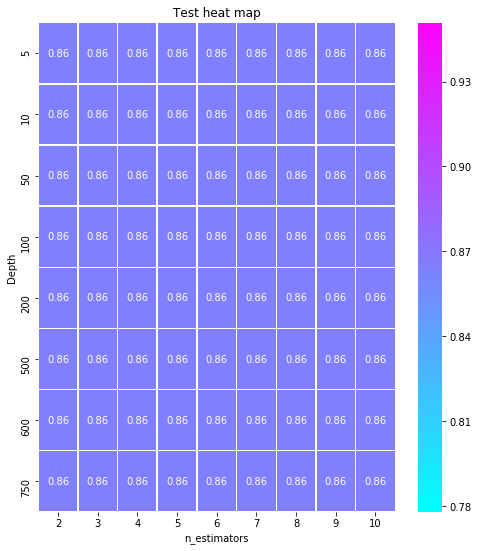

In [69]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index=len(param_grid['n_estimators']) 
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(test3.reshape(Index, Cols), index=param_grid['n_estimators'] , columns=param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Test heat map")
plt.xlabel("n_estimators")
plt.ylabel("Depth")
plt.show()



In [70]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_train,model3.predict(xtfidf))
cm3

array([[ 6839,   812],
       [ 3903, 37446]])

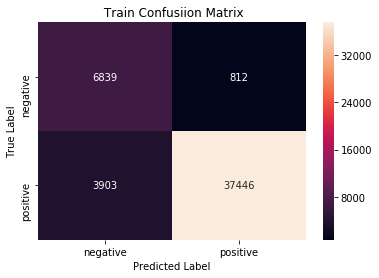

In [71]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title(" Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [72]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test,model3.predict(xtstfidf))
cm3

array([[ 2119,  1183],
       [ 2169, 15529]])

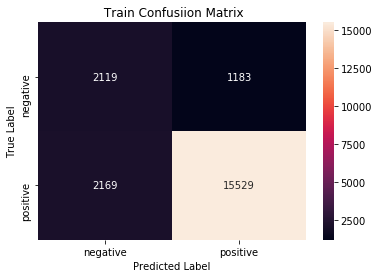

In [73]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title(" Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.2] Applying GBDT using XGBOOST

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
# Please write all the code with proper documentation

In [0]:
X1=X.sample(35000)
Y1=Y.sample(35000)

In [40]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.3, random_state = 52)
print(X_train1.shape, y_train1.shape, x_test1.shape)

(24500,) (24500,) (10500,)


### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [41]:
#BoW
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
bowt1=count_vect.fit_transform(X_train1)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowts1 = count_vect.transform(x_test1)
print("the type of count vectorizer ",type(bowts1))
print("the shape of out text BOW vectorizer ",bowts1.get_shape())
print("the number of unique words ", bowts1.get_shape()[1])

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundant', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10500, 6095)
the number of unique words  6095


In [42]:
#Train the model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Learning_rate = [0.05,0.12,0.25,0.3]

param_grid = {'n_estimators': trees, 'max_depth':depth, 'learning_rate':Learning_rate,}
GBD = GradientBoostingClassifier(max_features=0.2,subsample=0.1,)
GBD.fit(bowt1, y_train1)
model = GridSearchCV(GBD, param_grid, scoring = 'roc_auc', cv=5 , n_jobs = -2,pre_dispatch=3)
model.fit(bowt1,y_train1)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy on train data = ", model.best_score_*100)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=2,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy on train data =  51.57231258107766


In [43]:
#Assigning the result
Features = model.best_params_
optimal_depth = Features.get('max_depth')
optimal_estimator = Features.get('n_estimators')
print(optimal_depth)
print(optimal_estimator)


2
200


In [0]:
#Training with max depth and estimatore
clf = GradientBoostingClassifier(max_depth = optimal_depth,n_estimators=optimal_estimator)

clf.fit(bowt1,y_train1)

pred = clf.predict(bowts1)


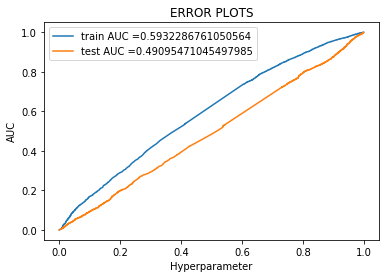

Train confusion matrix
[[  368  3510]
 [  851 19771]]
Test confusion matrix
[[  75 1614]
 [ 416 8395]]


In [45]:
train_fpr, train_tpr, thresholds = roc_curve(y_train1, model.predict_proba(bowt1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test1, model.predict_proba(bowts1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train1, model.predict(bowt1)))
print("Test confusion matrix")
print(confusion_matrix(y_test1, model.predict(bowts1)))

In [0]:
#Creating AUC array
auc_ts=[]
auc_tr=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc=auc(train_fpr, train_tpr)
    tsauc=auc(test_fpr, test_tpr)
    auc_ts.append(tsauc)
    auc_tr.append(trauc)
    
trainp=np.array(auc_tr)
testp=np.array(auc_ts)    

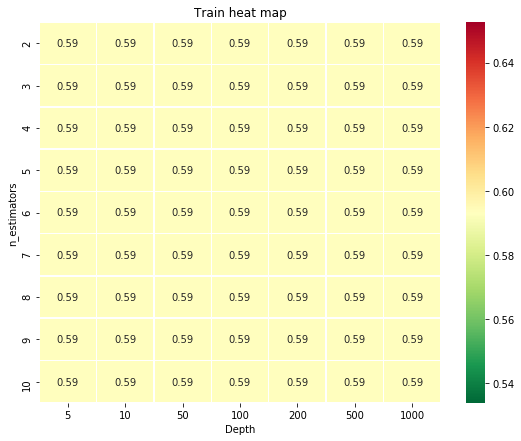

In [47]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(trainp.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



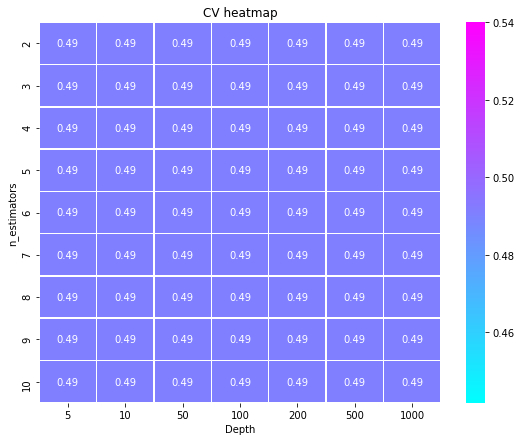

In [48]:
#Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(testp.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("CV heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [49]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1,model.predict(bowts1))
cm

array([[  75, 1614],
       [ 416, 8395]])

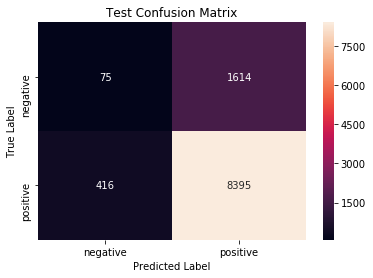

In [50]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train1, model.predict(bowt1))
cm

array([[  368,  3510],
       [  851, 19771]])

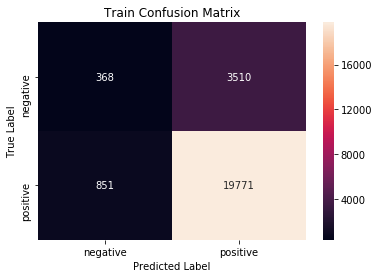

In [52]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [53]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tfidft1=tf_idf_vect.fit_transform(X_train1)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidfts1 = tf_idf_vect.transform(x_test1)
print("the type of count vectorizer ",type(tfidft1))
print("the shape of out text TFIDF vectorizer ",tfidft1.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidft1.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able purchase', 'able tell']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24500, 14446)
the number of unique words including both unigrams and bigrams  14446


In [54]:
#Traing model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Learning_rate = [0.05,0.125,0.25,0.5]

param_grid = {'n_estimators': trees, 'max_depth':depth, 'learning_rate':Learning_rate}
GBD = GradientBoostingClassifier(max_features=0.2,subsample=0.1,)
model1 = GridSearchCV(GBD, param_grid, scoring = 'roc_auc', cv=5 , n_jobs = -2,pre_dispatch=3)
model1.fit(tfidft1, y_train1)
print("Model with best parameters :\n",model1.best_estimator_)
print("Accuracy on train data = ", model1.best_score_*100)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=7,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy on train data =  51.09749012847979


In [55]:
#Assigning the result
Features1 = model1.best_params_
optimal_depth1 = Features1.get('max_depth')
optimal_estimator1 = Features1.get('n_estimators')
print(optimal_depth1)
print(optimal_estimator1)


7
500


In [0]:
#Training with max depth and estimatore
clf1 = GradientBoostingClassifier(max_depth = optimal_depth1,n_estimators=optimal_estimator1)

clf1.fit(tfidft1,y_train1)

pred1 = clf1.predict(tfidfts1)


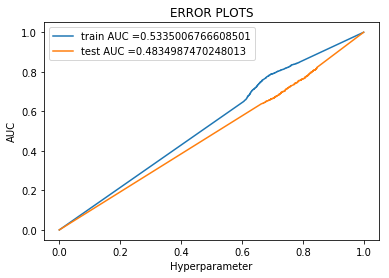

Train confusion matrix
[[ 1067  2811]
 [ 4001 16621]]
Test confusion matrix
[[ 322 1367]
 [1990 6821]]


In [57]:
train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train1, model1.predict_proba(tfidft1)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test1, model1.predict_proba(tfidfts1)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train1, model1.predict(tfidft1)))
print("Test confusion matrix")
print(confusion_matrix(y_test1, model1.predict(tfidfts1)))

In [0]:
#Creating AUC array
auc_ts1=[]
auc_tr1=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc=auc(train_fpr1, train_tpr1)
    tsauc=auc(test_fpr1, test_tpr1)
    auc_ts1.append(tsauc)
    auc_tr1.append(trauc)
    
trainxg1=np.array(auc_tr1)
testxg1=np.array(auc_ts1)    

In [0]:
ind=len(param_grid['max_depth'])

col=len(param_grid['n_estimators'])

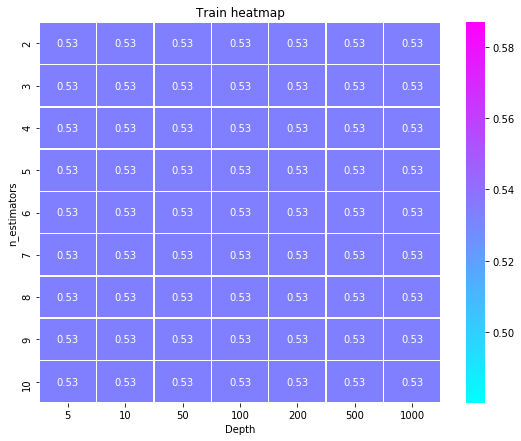

In [60]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(trainxg1.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))
sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()

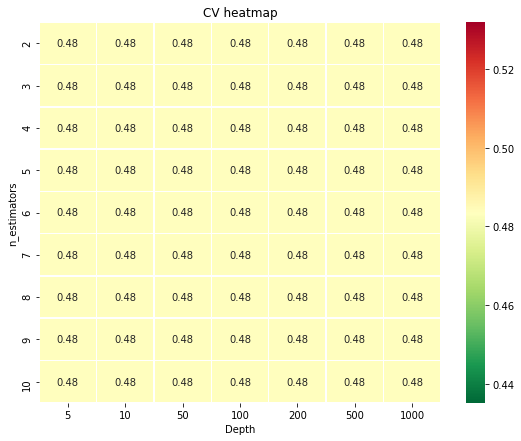

In [61]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(testxg1.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))
sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.title("CV heatmap")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [62]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_train1,model1.predict(tfidft1))
cm1

array([[ 1067,  2811],
       [ 4001, 16621]])

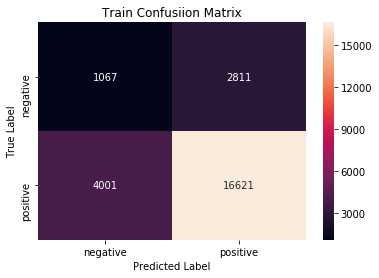

In [63]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test1,model1.predict(tfidfts1))
cm1

array([[ 322, 1367],
       [1990, 6821]])

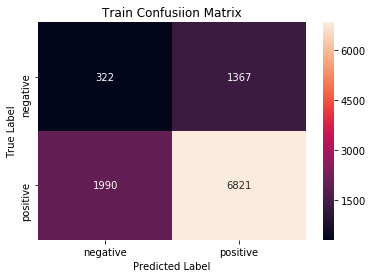

In [65]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train1.values:
    list_of_sent.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [68]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9908
sample words  ['using', 'grass', 'b', 'gone', 'around', 'flower', 'beds', 'years', 'time', 'saver', 'flowers', 'bloom', 'reason', 'not', 'able', 'find', 'stock', 'town', 'see', 'shipping', 'amazon', 'months', 'hmmm', 'might', 'need', 'order', 'anyway', 'next', 'year', 'normally', 'use', 'organic', 'products', 'no', 'great', 'make', 'exception', 'bought', 'tree', 'know', 'expect', 'reviews', 'arrived', 'today', 'seemingly', 'good', 'health', 'brown', 'spots', 'however']


In [69]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 24500/24500 [00:43<00:00, 569.41it/s]

24500


In [0]:
from sklearn import preprocessing
Xavg1=preprocessing.normalize(sent_vectors_tr)

In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in x_test1.values:
   list_of_sent_ts.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_ts=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=4)

In [73]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9908
sample words  ['using', 'grass', 'b', 'gone', 'around', 'flower', 'beds', 'years', 'time', 'saver', 'flowers', 'bloom', 'reason', 'not', 'able', 'find', 'stock', 'town', 'see', 'shipping', 'amazon', 'months', 'hmmm', 'might', 'need', 'order', 'anyway', 'next', 'year', 'normally', 'use', 'organic', 'products', 'no', 'great', 'make', 'exception', 'bought', 'tree', 'know', 'expect', 'reviews', 'arrived', 'today', 'seemingly', 'good', 'health', 'brown', 'spots', 'however']


In [74]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 10500/10500 [00:18<00:00, 575.07it/s]

10500
50


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg1 = preprocessing.normalize(sent_vectors)

In [77]:
#Traing model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Learning_rate = [0.05,0.145,0.45,0.55]

param_grid = {'n_estimators': trees, 'max_depth':depth, 'learning_rate':Learning_rate}
GBD = GradientBoostingClassifier(max_features=0.2,subsample=0.1,)
model2 = GridSearchCV(GBD, param_grid, scoring = 'roc_auc', cv=2 , n_jobs = -3,pre_dispatch=2)
model2.fit(Xavg1, y_train1)
print("Model with best parameters :\n",model2.best_estimator_)
print("Accuracy on train data = ", model2.best_score_*100)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.145, loss='deviance', max_depth=9,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy on train data =  51.69768797914512


In [78]:
#Assigning the result
Features2 = model2.best_params_
optimal_depth2 = Features2.get('max_depth')
optimal_estimator2 = Features2.get('n_estimators')
print(optimal_depth2)
print(optimal_estimator2)


9
10


In [79]:
#Training with max depth and estimatore
clf2 = GradientBoostingClassifier(max_depth = optimal_depth2,n_estimators=optimal_estimator2)
clf2.fit(Xavg1,y_train1)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

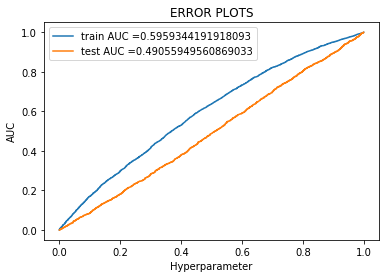

Train confusion matrix
[[  112  3766]
 [  330 20292]]
Test confusion matrix
[[  25 1664]
 [ 173 8638]]


In [80]:
train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train1, model2.predict_proba(Xavg1)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test1, model2.predict_proba(Xtsavg1)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train1, model2.predict(Xavg1)))
print("Test confusion matrix")
print(confusion_matrix(y_test1, model2.predict(Xtsavg1)))

In [0]:
#Creating AUC array
auc_ts2=[]
auc_tr2=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc2=auc(train_fpr2, train_tpr2)
    tsauc2=auc(test_fpr2, test_tpr2)
    auc_ts2.append(tsauc2)
    auc_tr2.append(trauc2)
    
trainxg2=np.array(auc_tr2)
testxg2=np.array(auc_ts2)    

In [0]:
ind=len(param_grid['max_depth'])

col=len(param_grid['n_estimators'])

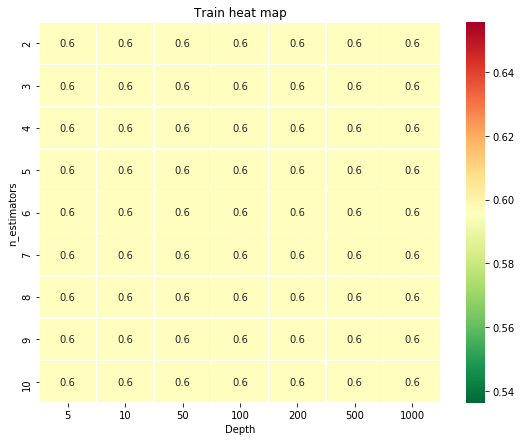

In [83]:
#Heatmap plot
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(trainxg2.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))
sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



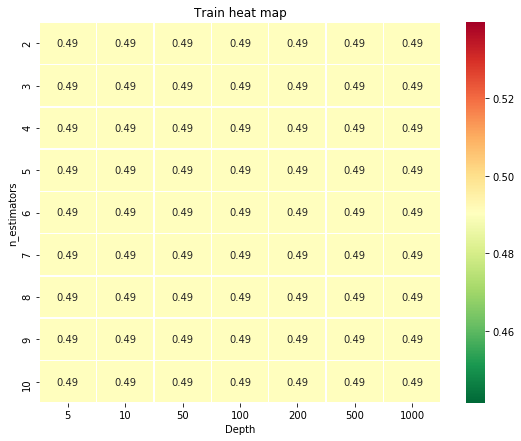

In [84]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(testxg2.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))
sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [85]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train1,model2.predict(Xavg1))
cm2

array([[  112,  3766],
       [  330, 20292]])

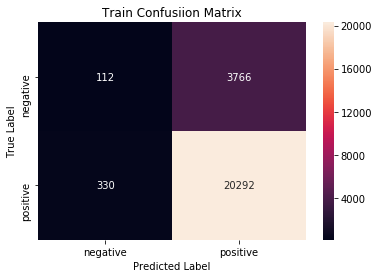

In [86]:
# plot confusion matrix .
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [87]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test1,model2.predict(Xtsavg1))
cm2

array([[  25, 1664],
       [ 173, 8638]])

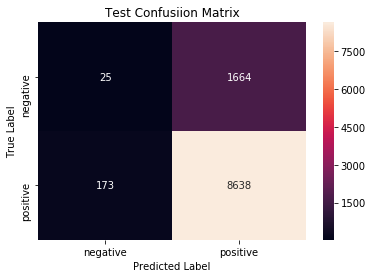

In [88]:
# plot confusion matrix .
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 24500/24500 [06:37<00:00, 61.56it/s]


In [0]:
from sklearn import preprocessing
xtfidf1 = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [92]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 10500/10500 [02:47<00:00, 62.85it/s]


In [0]:
xtstfidf1 = preprocessing.normalize(tfidf_sent_vectorsts)

In [94]:
#Traing model
trees = [5, 10, 50, 100, 200, 500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Learning_rate = [0.05,0.145,0.55,0.55]

param_grid = {'n_estimators': trees, 'max_depth':depth, 'learning_rate':Learning_rate}
GBD = GradientBoostingClassifier(max_features=0.2,subsample=0.1,)
model3 = GridSearchCV(GBD, param_grid, scoring = 'roc_auc', cv=2 , n_jobs = -3,pre_dispatch=2)
model3.fit(xtfidf1, y_train1)
print("Model with best parameters :\n",model3.best_estimator_)
print("Accuracy on train data = ", model3.best_score_*100)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.145, loss='deviance', max_depth=8,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy on train data =  52.18411002154802


In [95]:
#Assigning the result
Features3 = model3.best_params_
optimal_depth3 = Features3.get('max_depth')
optimal_estimator3 = Features3.get('n_estimators')
print(optimal_depth3)
print(optimal_estimator3)


8
200


In [96]:
#Training with max depth and estimatore
clf3 = GradientBoostingClassifier(max_depth = optimal_depth3,n_estimators=optimal_estimator3)
clf3.fit(xtfidf1,y_train1)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

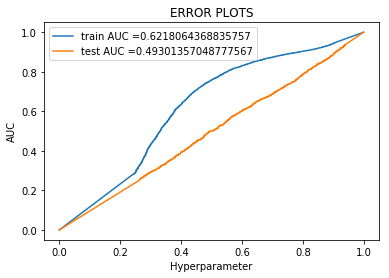

Train confusion matrix
[[ 1252  2626]
 [ 2761 17861]]
Test confusion matrix
[[ 298 1391]
 [1658 7153]]


In [97]:
#AUC curves
train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train1, model3.predict_proba(xtfidf1)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test1, model3.predict_proba(xtstfidf1)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train1, model3.predict(xtfidf1)))
print("Test confusion matrix")
print(confusion_matrix(y_test1, model3.predict(xtstfidf1)))

In [0]:
#Creating AUC array
auc_ts3=[]
auc_tr3=[]
for i in param_grid['max_depth']:
  for j in param_grid['n_estimators']:
    trauc3=auc(train_fpr3, train_tpr3)
    tsauc3=auc(test_fpr3, test_tpr3)
    auc_ts3.append(tsauc3)
    auc_tr3.append(trauc3)
    
train3=np.array(auc_tr3)
test3=np.array(auc_ts3)    

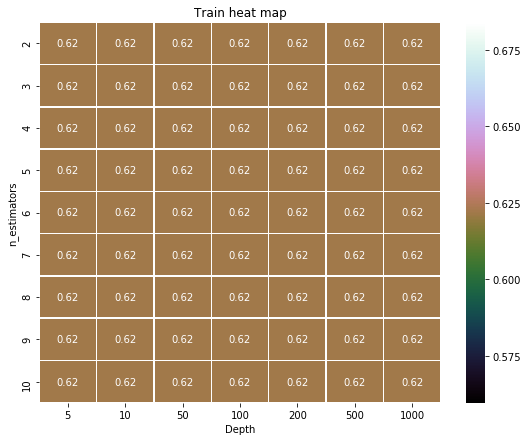

In [99]:
#Heatmap plot
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(train3.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cubehelix', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



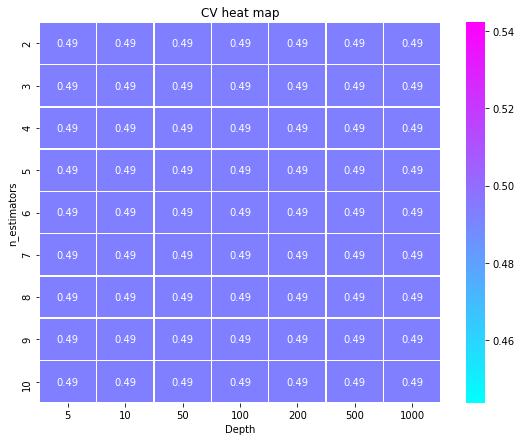

In [100]:
#Heatmap plot
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['max_depth'])
Cols =len(param_grid['n_estimators'])
df = pd.DataFrame(test3.reshape(Index, Cols), index=param_grid['max_depth'], columns=param_grid['n_estimators'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)

plt.title("CV heat map")
plt.xlabel("Depth")
plt.ylabel("n_estimators")
plt.show()



In [101]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_train1,model3.predict(xtfidf1))
cm3

array([[ 1252,  2626],
       [ 2761, 17861]])

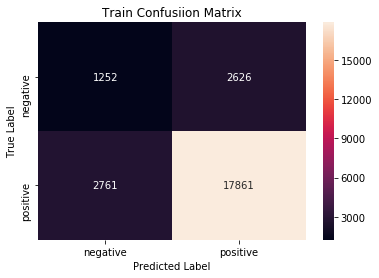

In [102]:
# plot confusion matrix .
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [103]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test1,model3.predict(xtstfidf1))
cm3

array([[ 298, 1391],
       [1658, 7153]])

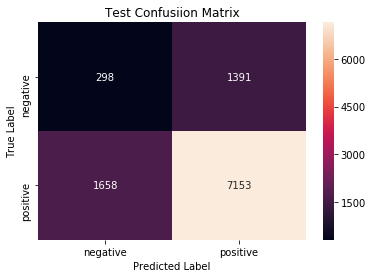

In [104]:
# plot confusion matrix .
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [4]:
#pretty table

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Vectoriser model","Tree","Depth" , "AUC", ]

p.add_row(["BOW","RF", "10", 0.91,] )
p.add_row(["TFIDF", "RF","10", 0.90,] )
p.add_row(["AVG TFIDF","RF", "10",0.88,] )
p.add_row(["TFIDF W2V","RF", "10", 0.86,] )

p.add_row(["BOW","XGBoost", "2", 0.48,] )
p.add_row(["TFIDF", "XGBoost","7", 0.49,] )
p.add_row(["AVG TFIDF","XGBoost", "9", 0.49,] )
p.add_row(["TFIDF W2V","XGBoost", "8", 0.49,] )
print(p)

+------------------+---------+-------+------+
| Vectoriser model |   Tree  | Depth | AUC  |
+------------------+---------+-------+------+
|       BOW        |    RF   |   10  | 0.91 |
|      TFIDF       |    RF   |   10  | 0.9  |
|    AVG TFIDF     |    RF   |   10  | 0.88 |
|    TFIDF W2V     |    RF   |   10  | 0.86 |
|       BOW        | XGBoost |   2   | 0.48 |
|      TFIDF       | XGBoost |   7   | 0.49 |
|    AVG TFIDF     | XGBoost |   9   | 0.49 |
|    TFIDF W2V     | XGBoost |   8   | 0.49 |
+------------------+---------+-------+------+


Observations

* Applied all vectoriser models to RF and GBDT.
* Hyperparameters are trained using gridsearch.
* Optimal depth and optimal estimators are used for training model. 
*  Used less no dataset in XGBoost as it takes long time to train.
*  Performance in RF is optimal. XGBoost is degraded as less dataset used for modelling.
*  Bagging is applied in RF as it improves model performance decreasing variance.
* Bow has provided maximum AUC.
*  Heatmap is plotted for AUC vs N-estimators vs Depth

